In [1]:
from drought.visualization import plot
from drought.data import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from drought.data.aggregator import get_monthly_means_and_shot_count
import drought.data.df_extensions as dfext
import drought.data.interpolate as interpolate
import seaborn as sns
import numpy as np

As observed in the notebook GEDIDataAnalytics, we have some outliers in GEDI pai values that likely stem from insufficient number of shots for that month. In this notebook, we'll explore the ways in which we can process that data to obtain more realistic GEDI data points.

## Get GEDI footprints and monthly data

In [2]:
footprints = pipeline.get_filtered_gedi_footprints()

In [4]:
monthly = get_monthly_means_and_shot_count(footprints, columns=['pai', 'rh100'])

In [4]:

index_columns = ['year', 'month', 'polygon_id']

# Get number of footprints shots per month per year, stored in a 'number'
# column.
shot_distribution = footprints.groupby(index_columns).count() \
                        .rename(columns={'pai': 'number'})[['number']]

# Calculate means per polygon per month per year.
mean_monthly = pd.read_csv('../../data/interim/gedi_PAI_fitted_monthly.csv', index_col=0).set_index(index_columns)

# Join the number of shots with data means
monthly = shot_distribution.join(mean_monthly).reset_index(
)[['pai', *index_columns, 'number']]


### Plot the data before any interpolation

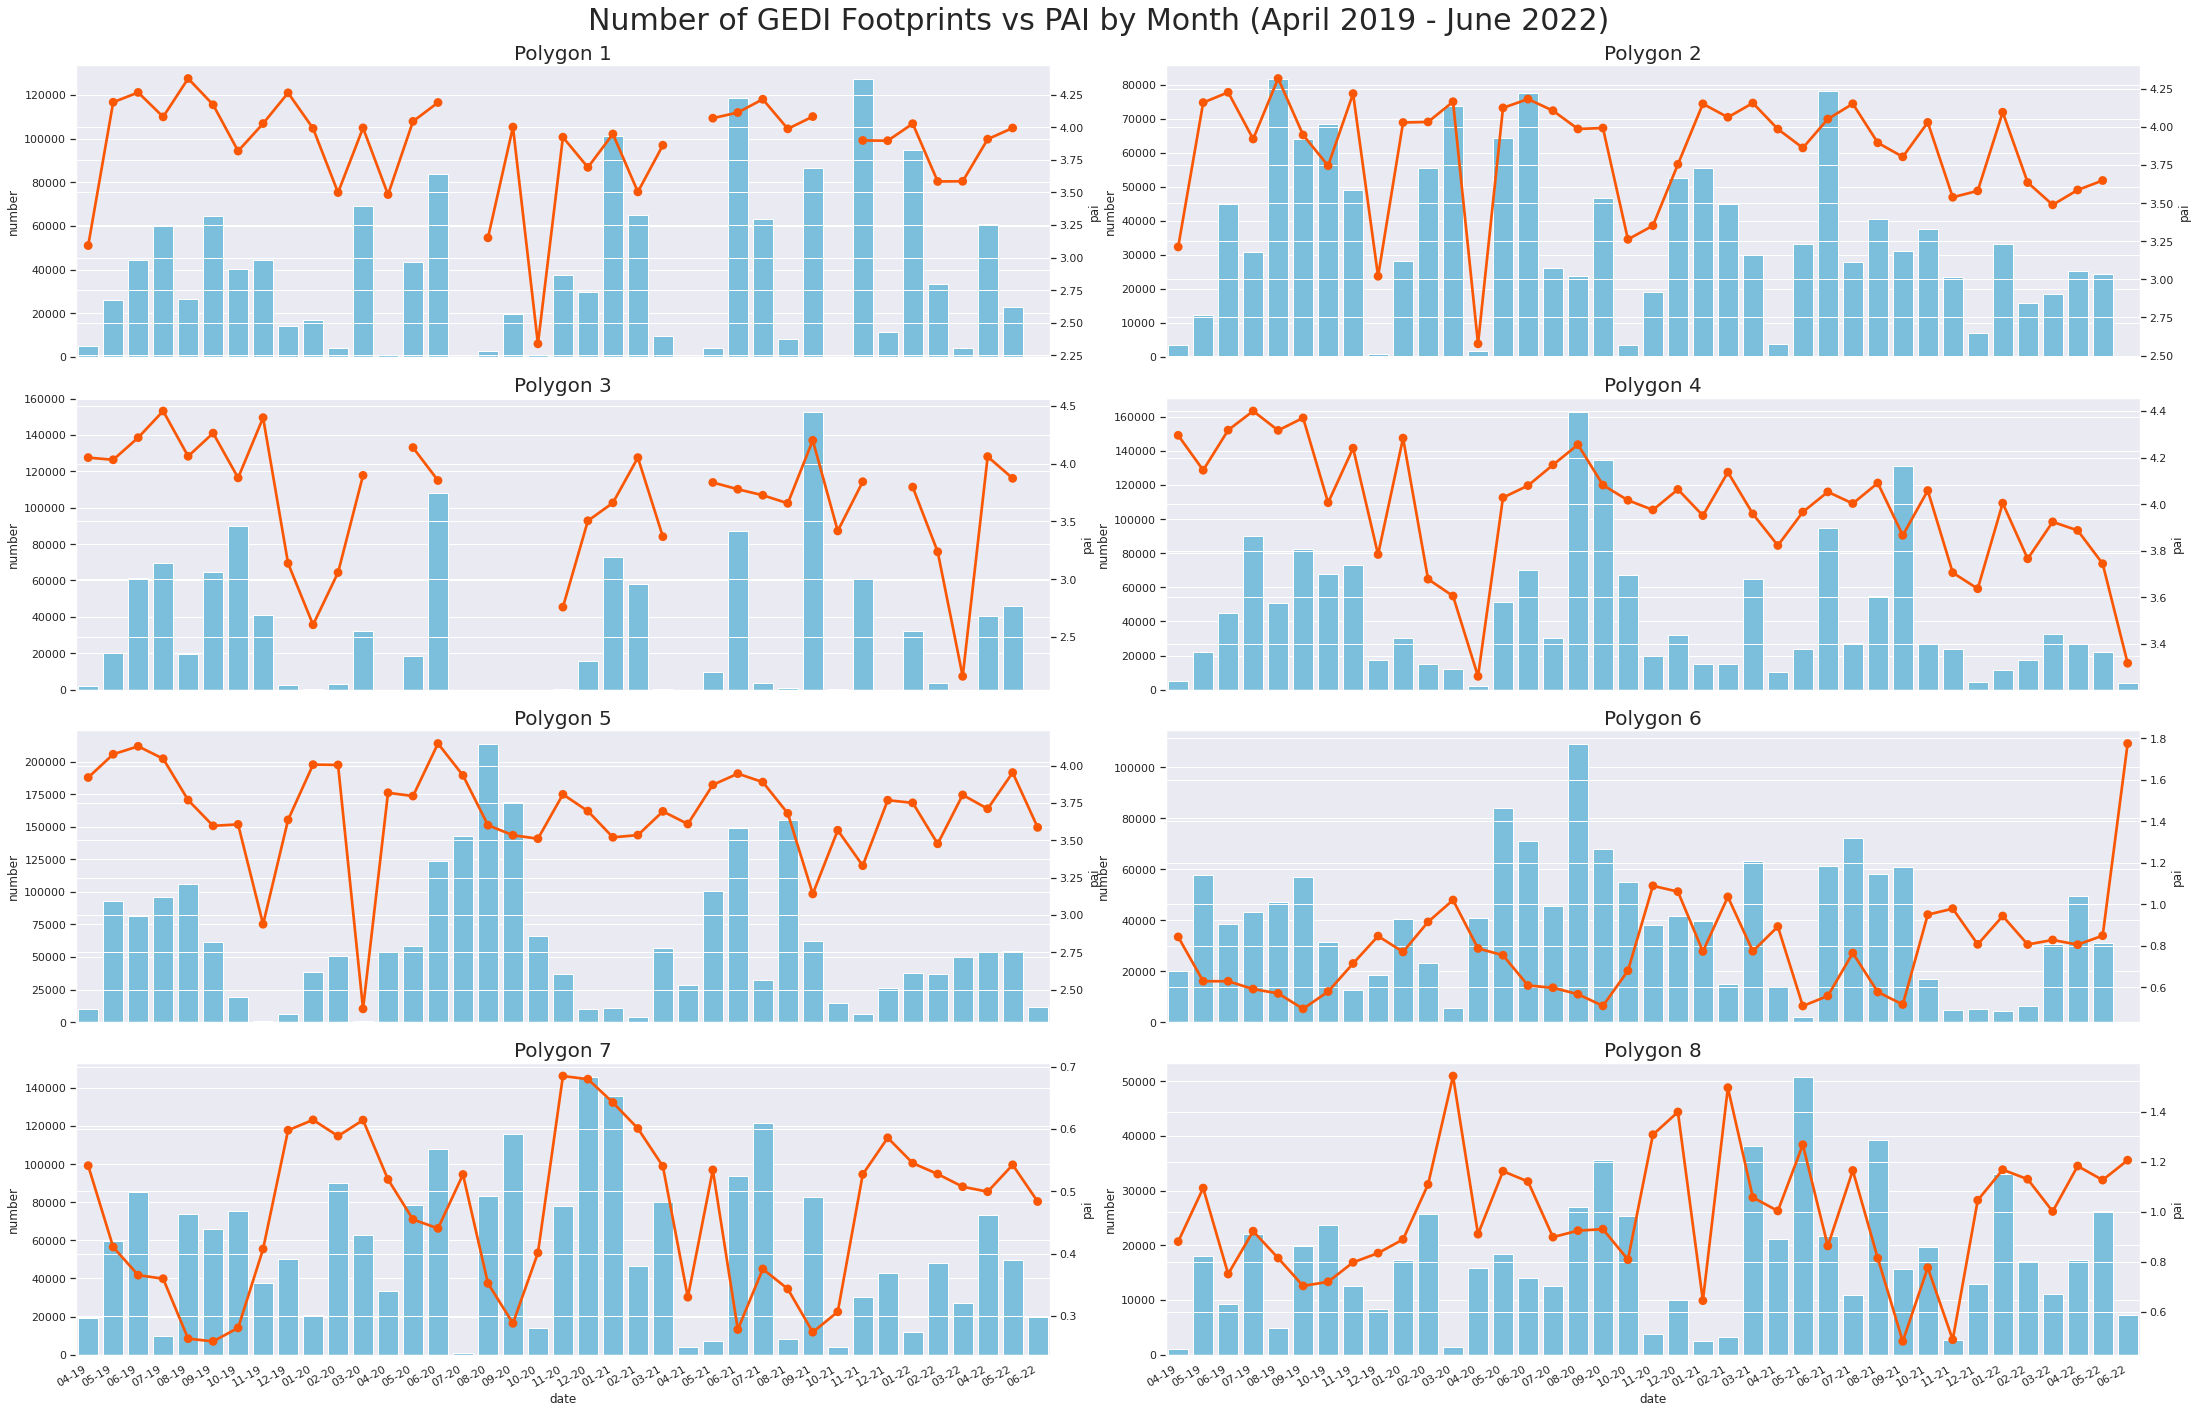

In [5]:
# Process data.
monthly_before = interpolate.fill_timeseries_missing_data(monthly, 
                                                          start_date='04-2019', 
                                                          end_date='07-2022', 
                                                          values_to_fill={'number': 0})
monthly_before = dfext.add_date_column(monthly_before)

# Plot
fig, ax = plot.layered_plot_per_polygon(monthly_before, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

## Interpolate data using weighted sliding window

We've observed that we have outlier data in the months where we've collected fewer number of GEDI shots.

Here we propose to interpolate the data to adjust the values for these outliers or months where we have missing data, relying on the data from adjacent months.

We make two assumptions:
1. There is a gradual PAI change from month to month, and we don't expect to see sudden large PAI changes in a single month. Specifically, we don't expect to see patterns of the kind low-high-low or high-low-high, where the middle month in the 3 month span is significantly different from the adjacent before and after months.
2. On average, months with more GEDI shots should yield more accurate PAI estimates than months with fewer GEDI shots.

We implement data interpolation based on these two assumptions in the following way:
* For each month, we take a look at the PAI value for the month and its two adjacent months - the month before and the month after. Let's call these previous, current, next.
* For each month, we keep track of two values: number of GEDI shots for that month, and PAI value. These are called 'number' and 'pai' respectively.
* Interpolated PAI value is then calculated in the following way:

  <font size="6">$pai_i = \frac{(pai_{i-1}\cdot number_{i-1} + pai_i\cdot number_i + pai_{i+1}\cdot number_{i+1})}{(number_{i-1} + number_i + number_{i+1})}$</font>

This interpolation method will do a weighted average for each 3 adjacent months, giving higher weight to months with more GEDI shots.

In [6]:
# Process data. Set missing pai values to zero, to avoid NaN sums.
monthly_interim = interpolate.fill_timeseries_missing_data(monthly, 
                                                           start_date='04-2019', 
                                                           end_date='07-2022', 
                                                           values_to_fill={'number': 0, 'pai': 0})
monthly_interim = dfext.add_date_column(monthly_interim)

In [7]:
monthly_after_weighted_average = interpolate.interpolate_using_weighted_average(monthly_interim, weight='number', value='pai')

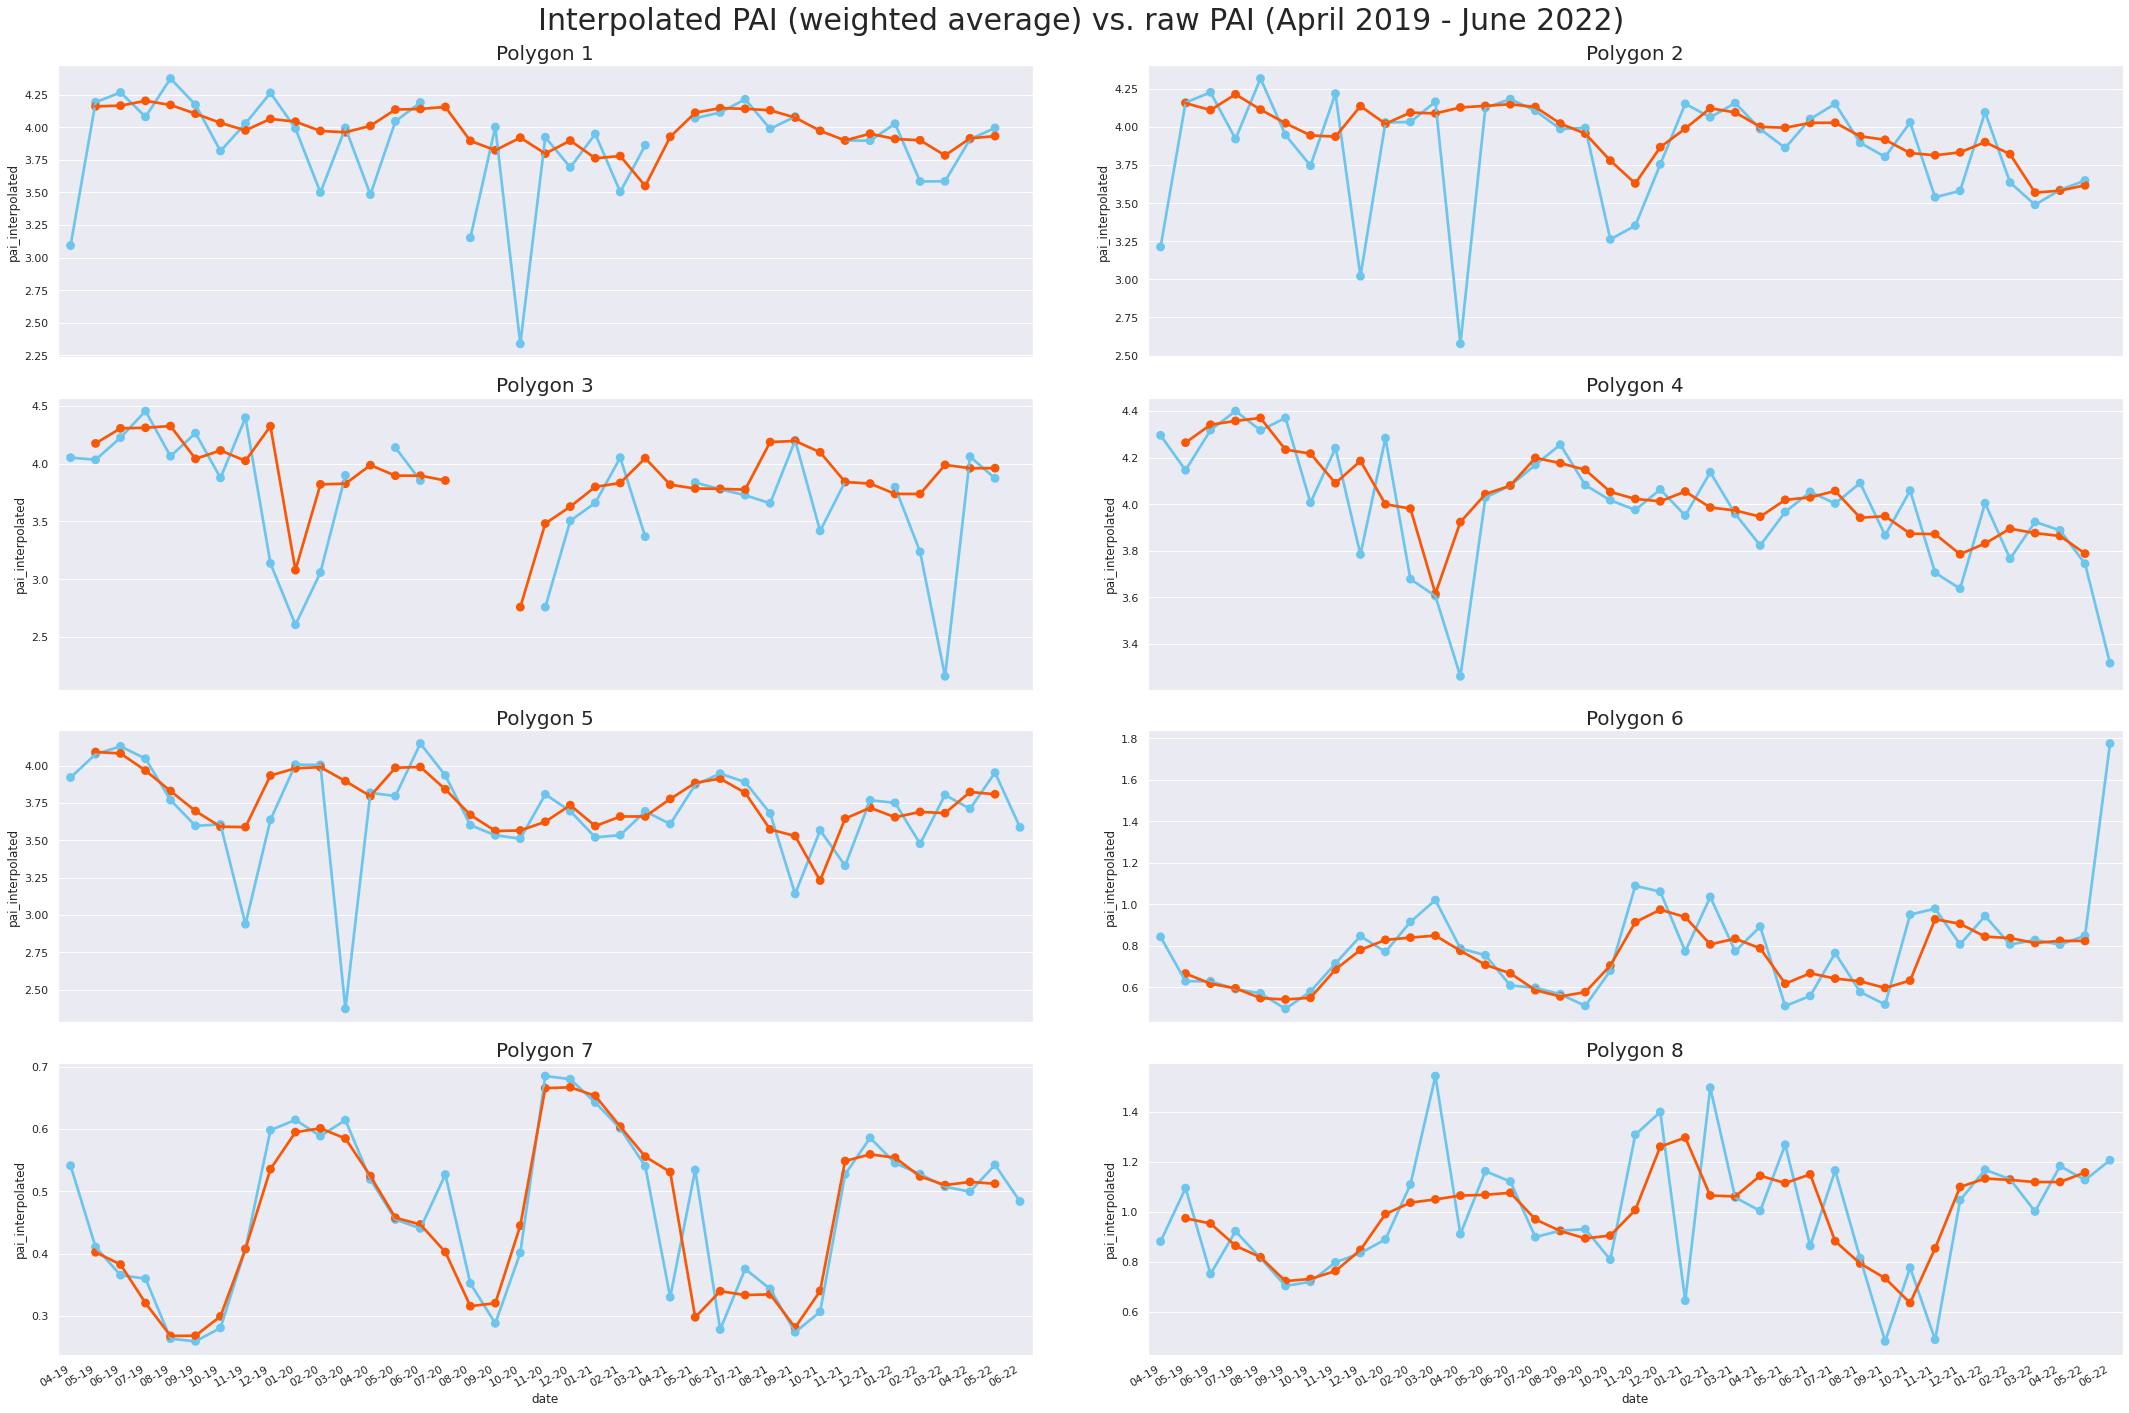

In [8]:
# Plot
monthly_after_weighted_average = monthly_after_weighted_average.replace({'pai': 0}, np.nan)
fig, ax = plot.layered_pointplot_per_polygon(monthly_after_weighted_average, 
                                             x='date',
                                             y1='pai',
                                             y2='pai_interpolated',
                                             title="Interpolated PAI (weighted average) vs. raw PAI (April 2019 - June 2022)") # noqa: E501


fig.autofmt_xdate()
plt.show()

### Save the interpolated data

In [11]:
monthly_after_weighted_average.to_csv("../../data/interim/gedi_monthly_interpolated_via_weighted_average.csv")